## Random Forests, XGBoost & Ensemble

In [1]:
# imports

import os
import re
import math
import json
from tqdm import tqdm
import random
from dotenv import load_dotenv
from huggingface_hub import login
import numpy as np
import pickle
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import chromadb
from items import Item
from testing import Tester
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import joblib


In [2]:
# CONSTANTS
QUESTION = "How much does this cost to the nearest dollar?\n\n"
DB = "products_vectorstore"

In [3]:
# environment
load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [4]:
# Load in the test pickle file:
with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [5]:
client = chromadb.PersistentClient(path=DB)
collection = client.get_or_create_collection('products')

In [6]:
result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
prices = [metadata['price'] for metadata in result['metadatas']]

# Random Forest

We will now train a Random Forest model.

Using the vectors we already have in Chroma, from the SentenceTransformer model.

In [7]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(vectors, prices)

RandomForestRegressor(n_jobs=-1, random_state=42)

# Gradient Boosting

In [7]:
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(vectors, prices)

GradientBoostingRegressor(random_state=42)

In [ ]:
# Save the model to a file

joblib.dump(rf_model, 'random_forest_model.pkl')
joblib.dump(gb_model, 'gradient_boosting_model.pkl')

In [7]:
# Load it back in again

rf_model = joblib.load('random_forest_model.pkl')
gb_model = joblib.load('gradient_boosting_model.pkl')

In [8]:
from agents.specialist_agent import SpecialistAgent
from agents.frontier_agent import FrontierAgent
from agents.random_forest_agent import RandomForestAgent
from agents.gradient_boosting_agent import GradientBoostingAgent

In [9]:
specialist = SpecialistAgent()
frontier = FrontierAgent(collection)
random_forest = RandomForestAgent()
gradient_boosting = GradientBoostingAgent()

In [10]:
def description(item):
    return item.prompt.split("to the nearest dollar?\n\n")[1].split("\n\nPrice is $")[0]

In [12]:
def rf(item):
    return random_forest.price(description(item))

1: Guess: $291.59 Truth: $374.41 Error: $82.82 SLE: 0.06 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $204.82 Truth: $225.11 Error: $20.29 SLE: 0.01 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $206.03 Truth: $61.68 Error: $144.35 SLE: 1.43 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $364.85 Truth: $599.99 Error: $235.14 SLE: 0.25 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $219.07 Truth: $16.99 Error: $202.08 SLE: 6.27 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $57.33 Truth: $31.99 Error: $25.34 SLE: 0.32 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $272.17 Truth: $101.79 Error: $170.38 SLE: 0.96 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $235.98 Truth: $289.00 Error: $53.02 SLE: 0.04 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $316.78 Truth: $635.86 Error: $319.08 SLE: 0.48 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $175.79 Truth: $65.99 Error: $109.80 SLE

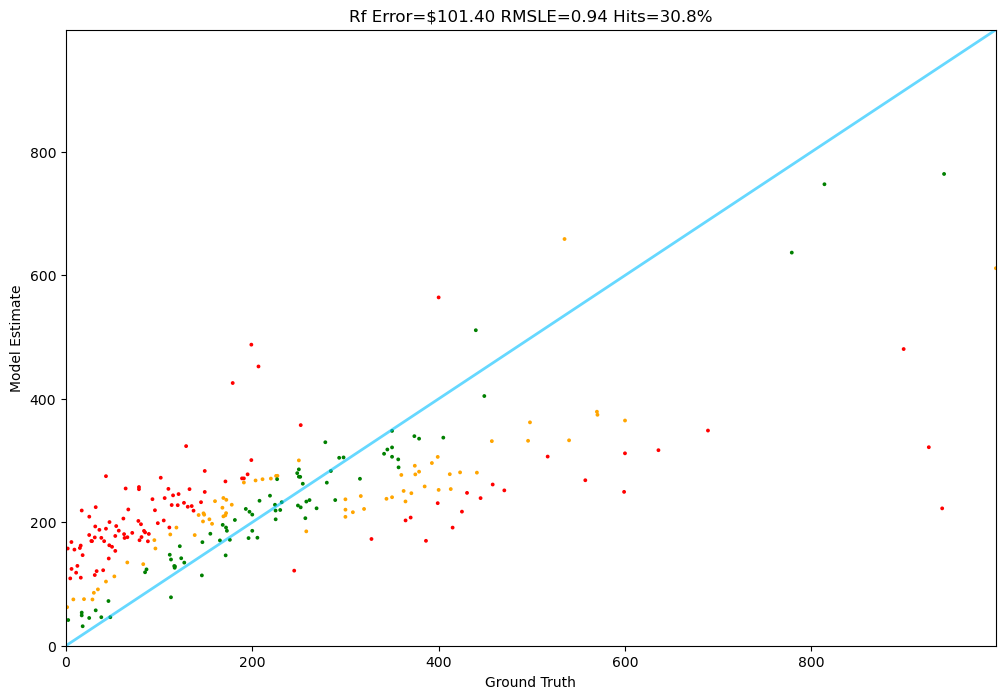

In [13]:
Tester.test(rf, test)

In [14]:
def gb(item):
    return gradient_boosting.price(description(item))

1: Guess: $278.30 Truth: $374.41 Error: $96.11 SLE: 0.09 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $203.69 Truth: $225.11 Error: $21.42 SLE: 0.01 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $282.90 Truth: $61.68 Error: $221.22 SLE: 2.28 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $273.28 Truth: $599.99 Error: $326.71 SLE: 0.62 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $215.50 Truth: $16.99 Error: $198.51 SLE: 6.19 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $119.24 Truth: $31.99 Error: $87.25 SLE: 1.67 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $291.20 Truth: $101.79 Error: $189.41 SLE: 1.09 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $264.52 Truth: $289.00 Error: $24.48 SLE: 0.01 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $324.30 Truth: $635.86 Error: $311.56 SLE: 0.45 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $215.60 Truth: $65.99 Error: $149.61 SL

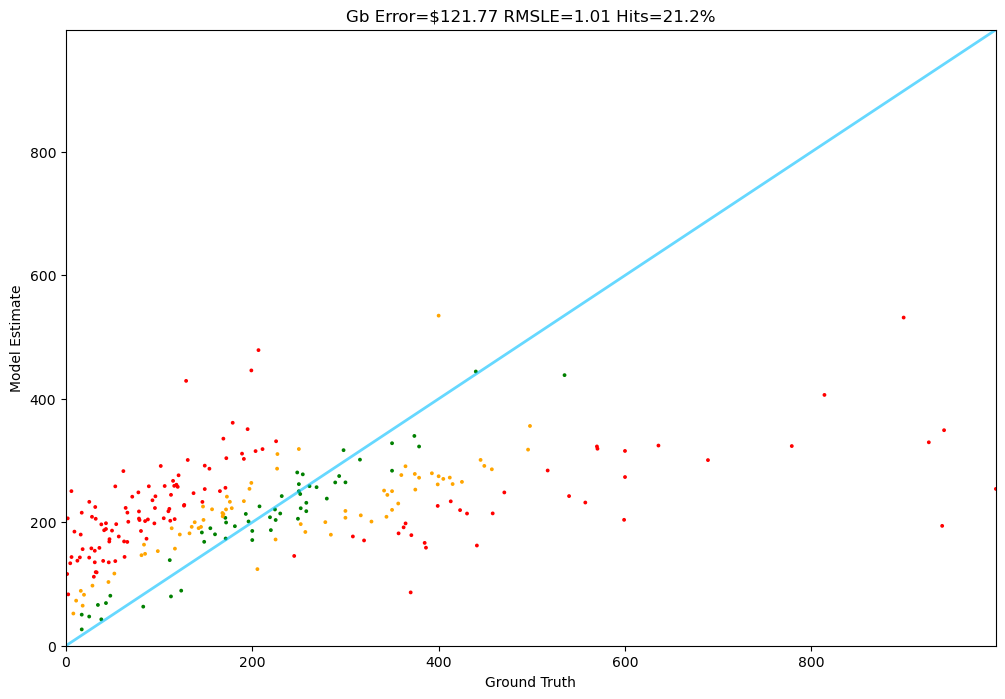

In [15]:
Tester.test(gb, test)

In [11]:
product = "Quadcast HyperX condenser mic for high quality audio for podcasting"

In [12]:
print(specialist.price(product))
print(frontier.price(product))
print(random_forest.price(product))
print(gradient_boosting.price(product))

189.0
154.59
296.79030000000023
227.5062013552033


In [13]:
specialists = []
frontiers = []
random_forests = []
gradient_boostings = []
prices = []
for item in tqdm(test[1000:1250]):
    text = description(item)
    specialists.append(specialist.price(text))
    frontiers.append(frontier.price(text))
    random_forests.append(random_forest.price(text))
    gradient_boostings.append(gradient_boosting.price(text))
    prices.append(item.price)

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [15:38<00:00,  3.75s/it]


In [15]:
mins = [min(s,f,r,g) for s,f,r,g in zip(specialists, frontiers, random_forests, gradient_boostings)]
maxes = [max(s,f,r,g) for s,f,r,g in zip(specialists, frontiers, random_forests, gradient_boostings)]

X = pd.DataFrame({
    'Specialist': specialists,
    'Frontier': frontiers,
    'RandomForest': random_forests,
    'GradientBoosting' : gradient_boostings,
    'Min': mins,
    'Max': maxes,
})

# Convert y to a Series
y = pd.Series(prices)

In [16]:
# Train a Linear Regression
np.random.seed(42)

lr = LinearRegression()
lr.fit(X, y)

feature_columns = X.columns.tolist()

for feature, coef in zip(feature_columns, lr.coef_):
    print(f"{feature}: {coef:.2f}")
print(f"Intercept={lr.intercept_:.2f}")

Specialist: 0.75
Frontier: 0.45
RandomForest: -0.02
GradientBoosting: 0.09
Min: -0.15
Max: -0.16
Intercept=24.08


In [17]:
joblib.dump(lr, 'ensemble_model.pkl')

['ensemble_model.pkl']

In [18]:
from agents.ensemble_agent import EnsembleAgent
ensemble = EnsembleAgent(collection)

In [19]:
ensemble.price(product)

177.20276709193624

In [20]:
def ensemble_pricer(item):
    return max(0,ensemble.price(description(item)))

1: Guess: $414.77 Truth: $374.41 Error: $40.36 SLE: 0.01 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $210.12 Truth: $225.11 Error: $14.99 SLE: 0.00 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $50.48 Truth: $61.68 Error: $11.20 SLE: 0.04 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $380.50 Truth: $599.99 Error: $219.49 SLE: 0.21 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $25.65 Truth: $16.99 Error: $8.66 SLE: 0.15 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $48.76 Truth: $31.99 Error: $16.77 SLE: 0.17 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $120.04 Truth: $101.79 Error: $18.25 SLE: 0.03 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $343.88 Truth: $289.00 Error: $54.88 SLE: 0.03 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $867.46 Truth: $635.86 Error: $231.60 SLE: 0.10 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $69.98 Truth: $65.99 Error: $3.99 SLE: 0.00 It

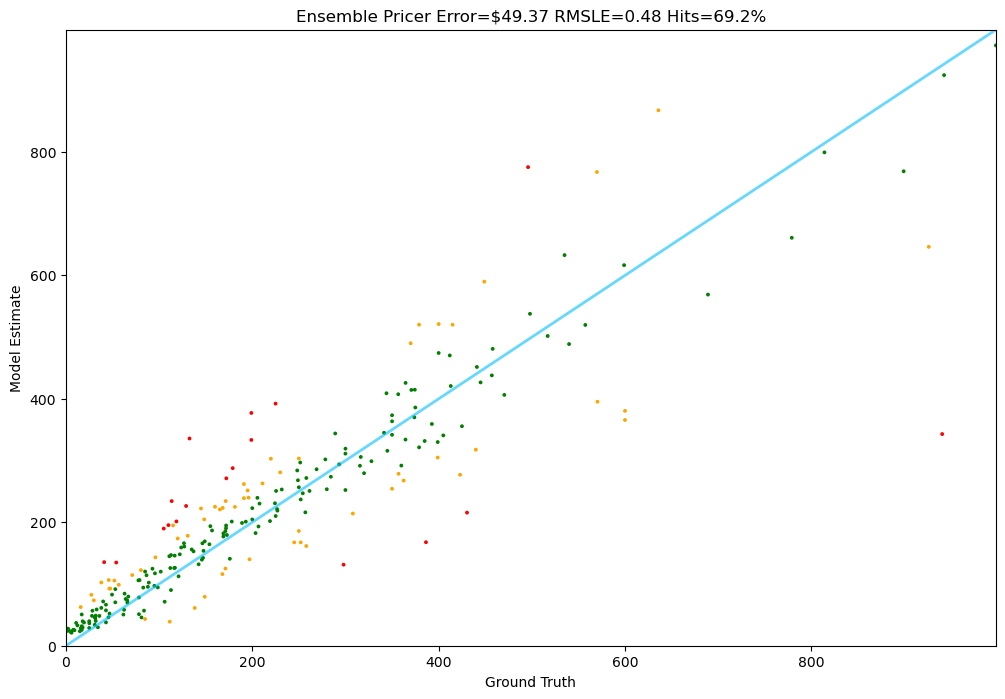

In [21]:
Tester.test(ensemble_pricer, test)